In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np

In [72]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [60]:
df = pd.read_csv("data/sales.csv")
df_nt = pd.read_csv('data/ironkaggle_notarget.csv')
df_s = pd.read_csv('data/ironkaggle_solutions.csv')

In [61]:
warnings.filterwarnings('ignore')

## Data exploration

In [62]:
df.head()

,True_index,Store_ID,Day_of_week,Date,Nb_customers_on_day,Open,Promotion,State_holiday,School_holiday,Sales
0,0,625,3,2013-11-06,641,1,1,0,0,7293
1,1,293,2,2013-07-16,877,1,1,0,1,7060
2,2,39,4,2014-01-23,561,1,1,0,0,4565
3,3,676,4,2013-09-26,1584,1,1,0,0,6380
4,4,709,3,2014-01-22,1477,1,1,0,0,11647


In [63]:
df.shape

(640840, 10)

In [64]:
df.dtypes

True_index              int64
Store_ID                int64
Day_of_week             int64
Date                   object
Nb_customers_on_day     int64
Open                    int64
Promotion               int64
State_holiday          object
School_holiday          int64
Sales                   int64
dtype: object

In [65]:
df.isna().sum()

True_index             0
Store_ID               0
Day_of_week            0
Date                   0
Nb_customers_on_day    0
Open                   0
Promotion              0
State_holiday          0
School_holiday         0
Sales                  0
dtype: int64

In [66]:
df.duplicated().sum()

0

## Data cleaning

In [67]:
def clean_data (df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['year'] = df['Date'].dt.year        # Año
    df['month'] = df['Date'].dt.month      # Mes
    df['day'] = df['Date'].dt.day          # Día del mes
    df['day_of_year'] = df['Date'].dt.dayofyear # Día del año
    df['is_weekend'] = df['Date'].dt.weekday >= 5  # Fin de semana (sábado o domingo)
    df['is_weekend'] = df['is_weekend'].astype(int)

    df = pd.get_dummies(df)
    df['State_holiday'] = df['State_holiday_0'].replace({True: 0, False: 1})
    df = df.drop(columns=['True_index', 'State_holiday_0', 'Date'])
    df['State_holiday_a'] = df['State_holiday_a'].astype(int)
    df['State_holiday_b'] = df['State_holiday_b'].astype(int)
    df['State_holiday_c'] = df['State_holiday_c'].astype(int)
    return df

In [68]:
df = clean_data(df)

## Data visualization

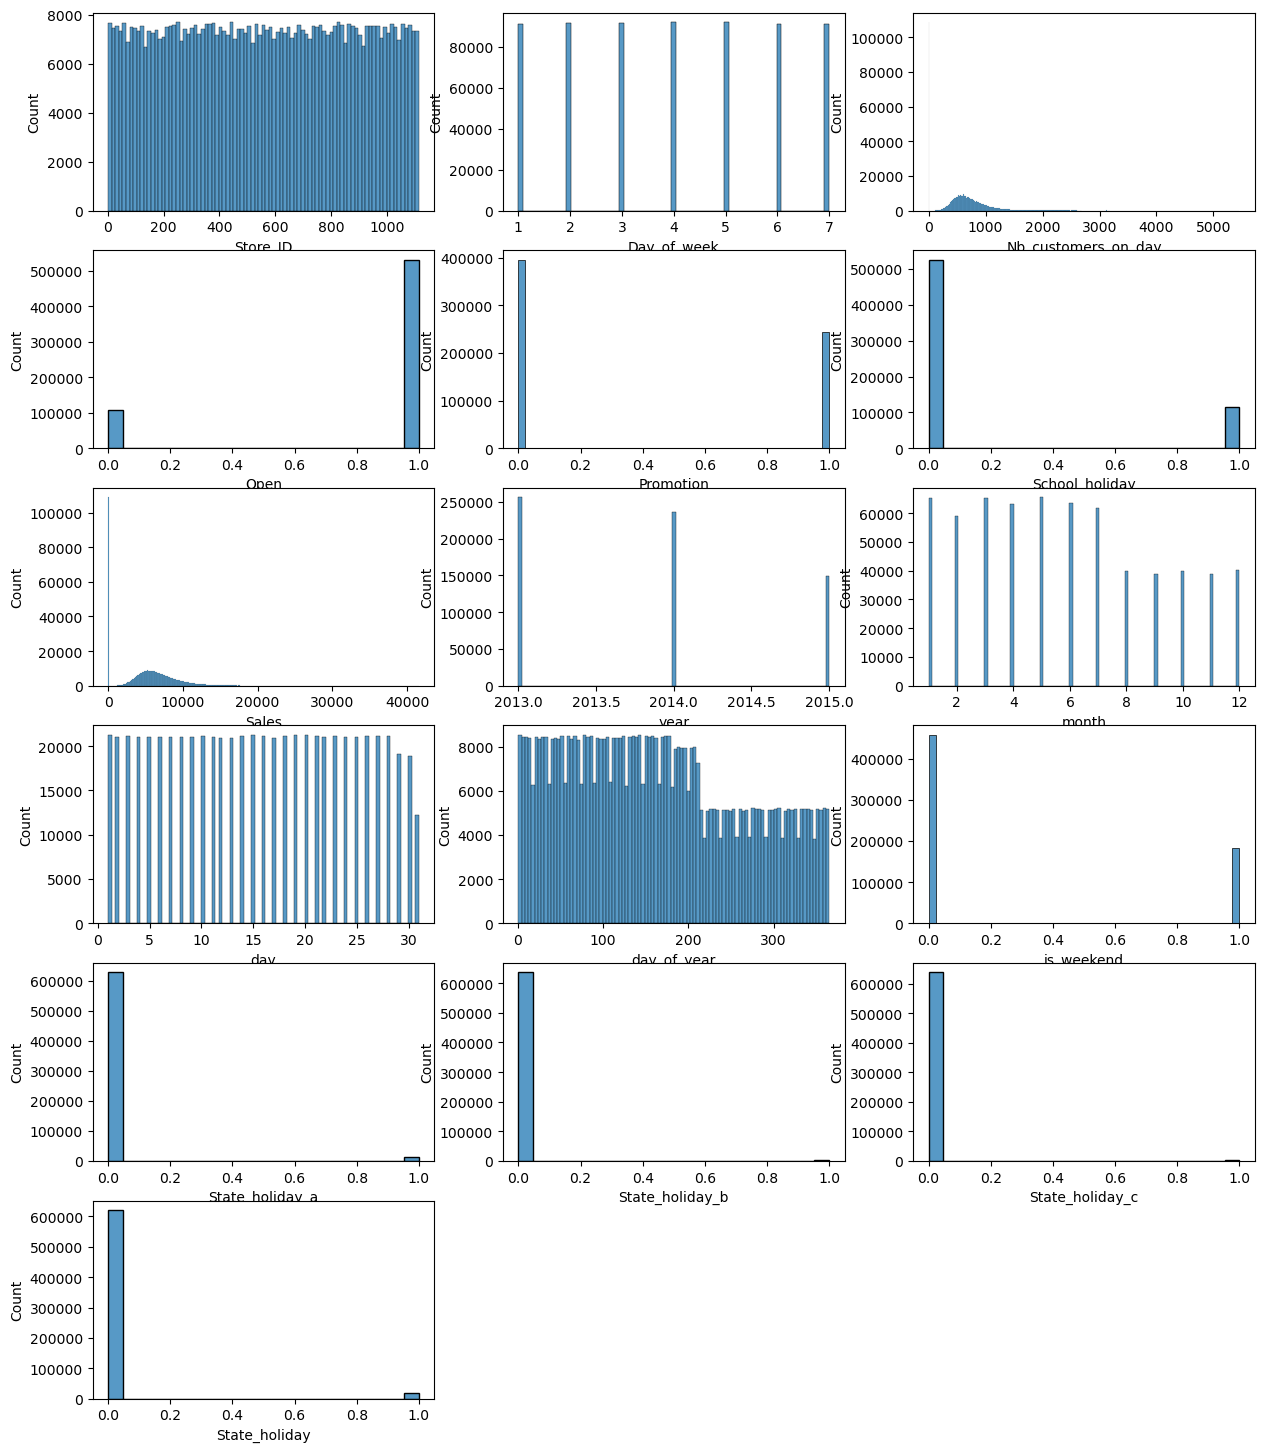

In [69]:
plt.figure(figsize = (15, 18))
for i, col in enumerate(df):
    plt.subplot(6, 3, i+1)
    sns.histplot(x = col, data = df)
    plt.xticks(rotation = 0)
plt.show()

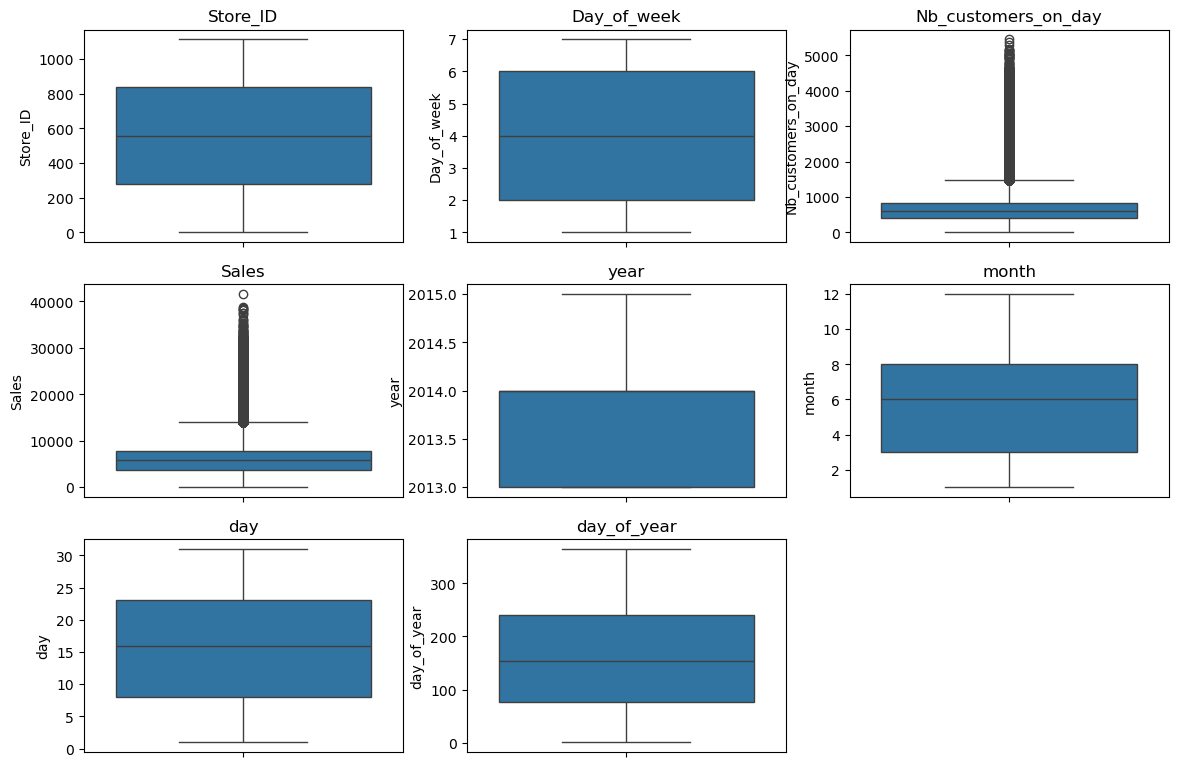

In [70]:
plt.figure(figsize=(14, 16))
for i, column in enumerate(df.drop(['Open', 'Promotion', 'School_holiday', 'State_holiday', 'State_holiday_a', 'State_holiday_b', 'State_holiday_c', 'is_weekend'], axis = 1).columns):
    plt.subplot(5, 3, i+1)
    sns.boxplot(data=df, y=column)
    plt.title(f'{column}')
plt.show()

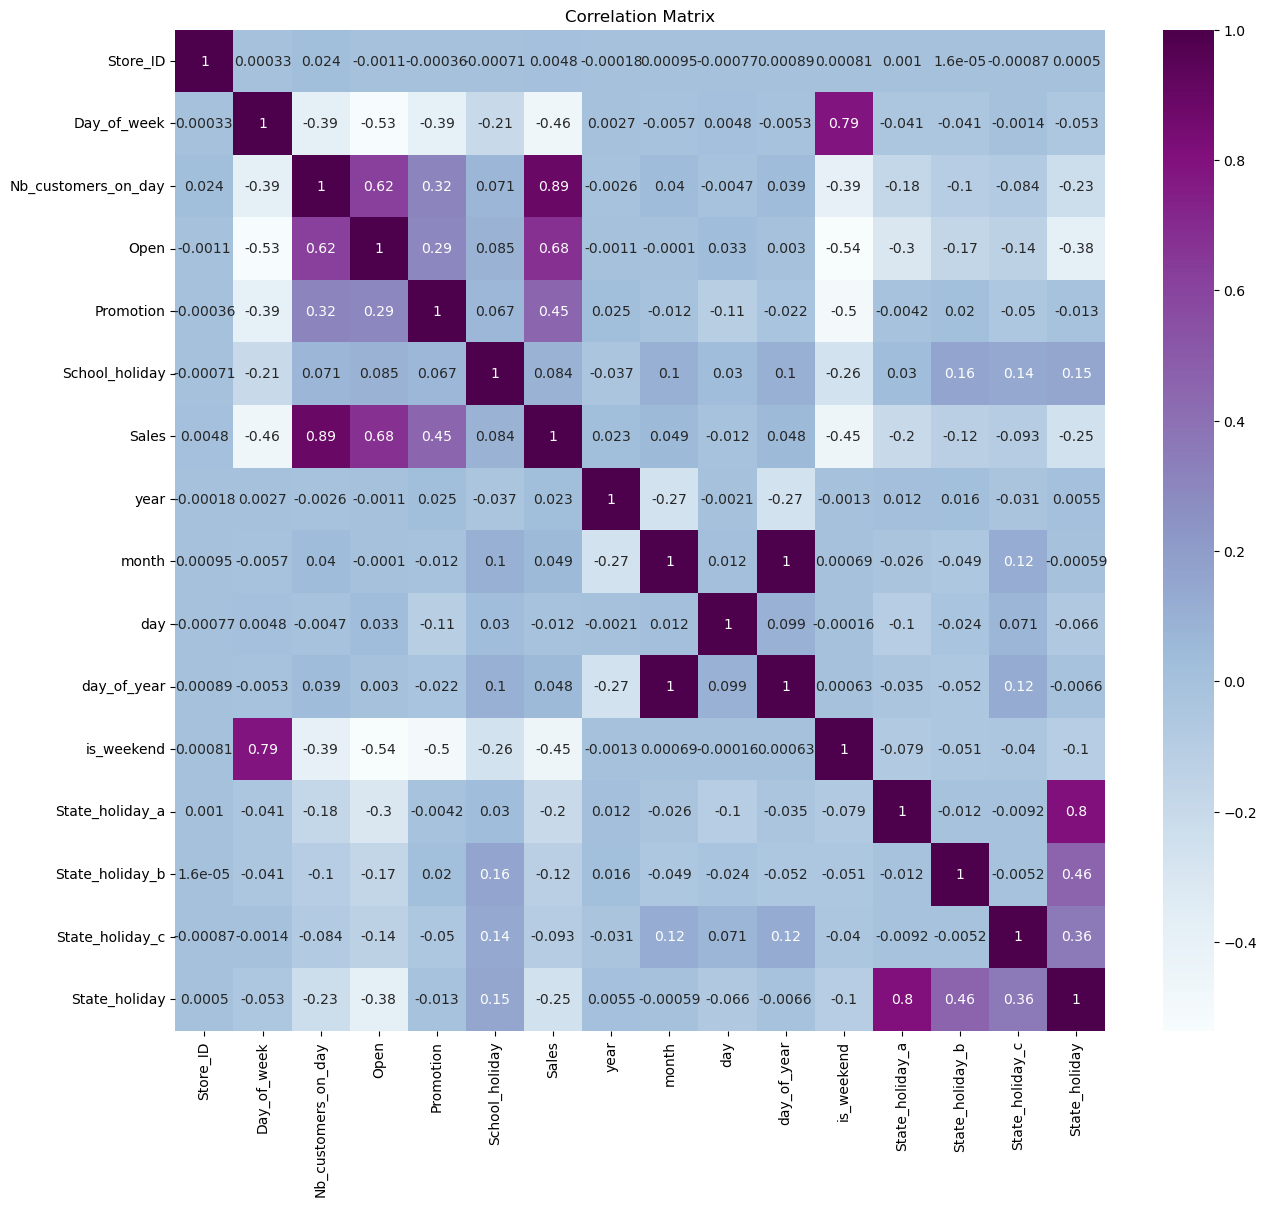

In [71]:
plt.figure(figsize=(15, 13))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap="BuPu")
plt.title("Correlation Matrix")
plt.show()

## Models

In [73]:
models = {'Linear Regression': LinearRegression(),
          'Decision Tree': DecisionTreeRegressor(max_depth=10)
}

In [74]:
X = df.drop(['Sales', 'Store_ID'], axis=1) 
y = df['Sales']

In [75]:
def remove_outliers(df, columns, z_threshold=3):
  columns = [col for col in columns if col in df.columns]
  return df[(np.abs(stats.zscore(df[columns])) < z_threshold).all(axis=1)]

# Prepare results DataFrame
results = []
conf = {}
i = 0

# Iterate through different scenarios
for outliers in ['With Outliers', 'Without Outliers']:
    for scaling in ['No Scaling', 'Standardization', 'Normalization']:
        # Prepare data
        X_subset = X.copy()

        if outliers == 'Without Outliers':
            X_subset = remove_outliers(X_subset, ['Nb_customers_on_day'])   
            y_subset = y[X_subset.index]
        else:
            y_subset = y

        X_train, X_test, y_train, y_test = train_test_split(X_subset, y_subset, test_size=0.2, random_state=42)

        if scaling == 'Standardization':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        elif scaling == 'Normalization':
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        # Train and evaluate models
        for model_name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)

            MAE = mean_absolute_error(y_test, y_pred)
            MSE = mean_squared_error(y_test, y_pred)
            RMSE = np.sqrt(MSE)
            R2score = r2_score(y_test, y_pred)
            i += 1

            results.append({
                'Model': model_name,
                'Outliers': outliers,
                'Scaling': scaling,
                'MAE': MAE,
                'MSE': MSE,
                'RMSE': RMSE,
                'R2_score': R2score
            })

results_df = pd.DataFrame(results)

In [76]:
results_df.sort_values(by='MAE' , ascending=True).style.background_gradient(cmap='Blues')

,Model,Outliers,Scaling,MAE,MSE,RMSE,R2_score
9,Decision Tree,Without Outliers,Standardization,852.171359,1618015.008711,1272.012189,0.874727
7,Decision Tree,Without Outliers,No Scaling,852.181004,1618182.826921,1272.078153,0.874714
11,Decision Tree,Without Outliers,Normalization,852.188077,1618068.935080,1272.033386,0.874723
3,Decision Tree,With Outliers,Standardization,883.660122,1818479.016117,1348.509924,0.879211
1,Decision Tree,With Outliers,No Scaling,883.717852,1818938.839487,1348.680407,0.879181
5,Decision Tree,With Outliers,Normalization,883.743143,1819219.160409,1348.784327,0.879162
6,Linear Regression,Without Outliers,No Scaling,929.001259,1811405.841940,1345.884780,0.859754
10,Linear Regression,Without Outliers,Normalization,929.001264,1811405.835254,1345.884778,0.859754
8,Linear Regression,Without Outliers,Standardization,929.003280,1811410.749259,1345.886603,0.859754
2,Linear Regression,With Outliers,Standardization,985.414615,2174759.536986,1474.706594,0.855546


In [78]:
X = df.drop(['Sales', 'Store_ID'], axis=1) 
y = df['Sales']

X = remove_outliers(X, ['Nb_customers_on_day'])   
y = y[X.index]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

model =  DecisionTreeRegressor(max_depth=10)
model.fit(X_scaled, y)

DecisionTreeRegressor(max_depth=10)

## Predictions

In [80]:
X_test = clean_data(df_nt)
X_test = X_test.drop(columns=['Store_ID'])
X_test = scaler.transform(X_test)

In [81]:
y_pred = model.predict(X_test)

In [83]:
mae_standardized = mean_absolute_error(df_s["Sales"], y_pred)
MSE = mean_squared_error(df_s["Sales"], y_pred)
RMSE = np.sqrt(MSE)
r2_standardized = r2_score(df_s["Sales"], y_pred)
mae_standardized, RMSE, r2_standardized

(554.3376487595373, 992.6476280134036, 0.9292184313489408)